# Plot the Distance Spectrum and Generate Inputs for the ML Model

generate distance spectrum...
dist spectrum h0


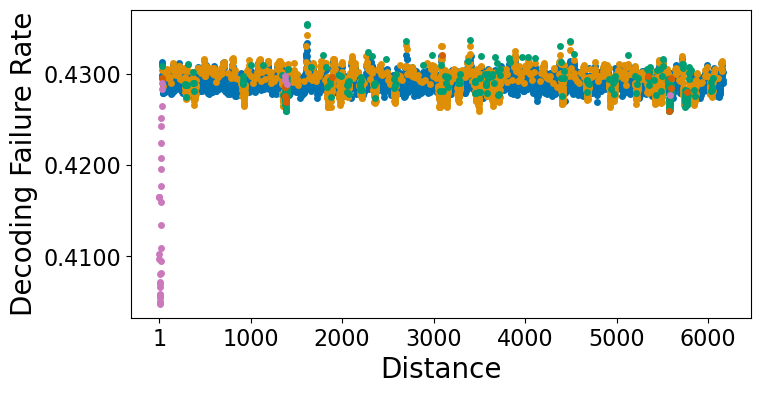

dist spectrum h1


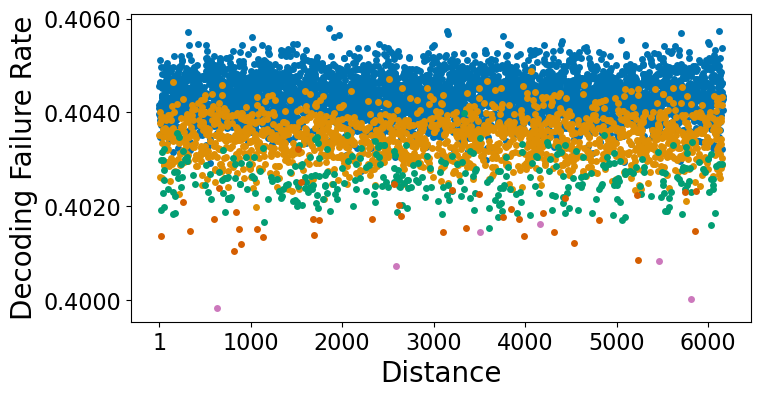

save DS for CNN analysis
get data from test_key
window data then save for analysis
Data saved to test_key/test_trace.csv


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import  ListedColormap
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from collections import defaultdict
from typing import Dict, List
import seaborn as sns


num_bits = 12323
num_bytes = 1541
num_dist = num_bits // 2 +1


# need
def is_bit_set(arr, i):
    return (arr[i // 8] & (1 << (i % 8))) != 0

# need
def get_wlist(arr):
    wlist = []
    for i in range(len(arr)):
        if arr[i] > 0:
            for b in range(8):
                if is_bit_set(arr, i*8+b):
                    wlist.append(i*8+b)
    return wlist

    
    # need
def get_distance_spec(arr):

    wlist = []
    if(len(arr) == num_bytes):
        # get wlist
        wlist = get_wlist(arr)
        wlist.sort()
    elif len(arr) == 71:
        # already wlist form
        wlist = arr
        wlist.sort()
    else:
        print("Danger uncommoen foramt of arr of len : ", len(arr))
        wlist = arr
        wlist.sort()
    
    max_dist = num_bits // 2
    dist = [0] * num_bits
    wlist_dist = []
    
    for x in range(len(wlist)):
        for y in range(x+1,len(wlist)):
            a = wlist[x]
            b = wlist[y]
            if b-a > max_dist:
                dist[num_bits - (b-a)] += 1
                wlist_dist.append(num_bits - (b-a))
            else:
                dist[b-a] += 1
                wlist_dist.append((b-a))

    return dist, wlist_dist


def get_key(file_path):
    # read private key
    with open(file_path, 'r') as file:
        hex_key = file.readline().strip()

    key = bytes.fromhex(hex_key)

    # 2*71*4bytes || 2* 1541 || ...
    w0 = []
    w1 = []
    pos = 0
    while(pos < 71*4) :
        result = int.from_bytes(key[pos:pos+4], byteorder='little')
        w0.append(result)
        pos +=4
    while(pos < 2*71*4) :
        result = int.from_bytes(key[pos:pos+4], byteorder='little')
        w1.append(result)
        pos +=4
    
    key_byte = 1541
    offset = 2*71*4
    h0 = key[offset:offset+key_byte]
    

    h1 = key[offset+key_byte:offset+2*key_byte]

    
    return w0, w1, h0, h1



def plot_DS(a, multiplicity_values, use_unique_markers=False, tickssize=16, labelsize=20):
    # Convert multiplicity_values to a numpy array.
    multiplicity_values = np.asarray(multiplicity_values)
    # Group together any multiplicity values >= 5, mapping them to 5.
    groups = np.where(multiplicity_values >= 4, 4, multiplicity_values)
    unique_vals = np.unique(groups)
    
    # Use a qualitative color palette ("colorblind").
    palette = sns.color_palette("colorblind", len(unique_vals))
    
    #custom_colors = ["#1f77b4", "#2ca02c", "#d62728"] 
    #palette = sns.color_palette(custom_colors)
    cmap = ListedColormap(palette)
    
    # Create a mapping from group value to index in the color palette.
    mapping = {val: idx for idx, val in enumerate(unique_vals)}
    
    # Define marker styles for each group.
    markers_list = ['o', 's', 'D', '^', 'v', '<', '>', 'p']
    markers_mapping = {val: markers_list[i % len(markers_list)] for i, val in enumerate(unique_vals)}
    
    # Define marker sizes (using fixed values for simplicity).
    size_min = 25
    size_max = 25  # Both sizes are equal in this example

    fig, ax = plt.subplots(figsize=(8, 4))


    # Plot the scatter for each group (using the remapped groups).
    for y in unique_vals:
        idx = np.where(groups == y)[0]
        color = cmap(mapping[y])
        marker = markers_mapping[y] if use_unique_markers else 'o'
        group_size = np.interp(y, (unique_vals.min(), unique_vals.max()), (size_min, size_max))
        ax.scatter(idx, a[idx], color=color, marker=marker, s=group_size,
                   edgecolors='black', linewidths=0)
    
    ax.set_xlabel('Distance', fontsize=labelsize)
    ax.set_ylabel('Decoding Failure Rate', fontsize=labelsize)
    ax.tick_params(axis='both', labelsize=tickssize)
    
    xticks = [1, 1000, 2000, 3000, 4000, 5000, 6000]
    ax.set_xticks(xticks)

    #ax.set_ylim(0.46, 0.47)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    plt.savefig("fig/my_plot.pdf", format="pdf", bbox_inches="tight")

    plt.show()


    
def safe_elementwise_division(a, b):
    with np.errstate(divide='ignore', invalid='ignore'):
        d = a/b
    d[np.isnan(d)] = 0
    return d


# reads chuncks of 100.000 * amount data
def read_dist_data(file_paths, amount):
    
    count_succ = 0
    count_sum = 0
    
    dist_spec_0 = np.zeros(num_bits, dtype=np.float32)
    dist_spec_sum_0 = np.zeros(num_bits, dtype=np.int32)
    dist_spec_1 = np.zeros(num_bits, dtype=np.float32)
    dist_spec_sum_1 = np.zeros(num_bits, dtype=np.int32)
    
    cur_raed = 0
    for file_path in file_paths:
        if amount == 0:
            break
        with open(file_path, 'r') as file:
            for line in file:
                if amount == 0:
                    break
                data_string = line.strip()
                data_list = data_string.split(',')
                # Remove leading and trailing whitespace from each substring
                data_list = [x.strip() for x in data_list if x.strip()]#
                

                if(cur_raed == 0):
                    data = list(map(int, data_list))
                    count_succ += data[0]
                    count_sum += data[1]
                if(cur_raed == 1):
                    data = list(map(float, data_list))
                    dist_spec_0 = np.array([x + y for x, y in zip(dist_spec_0, data)])
                if(cur_raed == 2):
                    data = list(map(int, data_list))
                    dist_spec_sum_0 = np.array([x + y for x, y in zip(dist_spec_sum_0, data)])
                if(cur_raed == 3):
                    data = list(map(float, data_list))
                    dist_spec_1 = np.array([x + y for x, y in zip(dist_spec_1, data)])
                if(cur_raed == 4):
                    data = list(map(int, data_list))
                    dist_spec_sum_1 = np.array([x + y for x, y in zip(dist_spec_sum_1, data)])

                cur_raed = (cur_raed +1) %5
                if(cur_raed == 0):
                    amount -=1  
        

    return count_succ, count_sum, dist_spec_0, dist_spec_sum_0, dist_spec_1, dist_spec_sum_1



## data for ML

def get_trace_data_file(file_path, data_name, amount):

    key_file_path = file_path + '/key.txt'

    data_file_path = []
    data_file_path.append(file_path + data_name)
 
    count_succ, count_sum, dist_spec_0, dist_spec_sum_0, dist_spec_1, dist_spec_sum_1 =  read_dist_data(data_file_path, amount) 
    DS_h0 = safe_elementwise_division(dist_spec_0, dist_spec_sum_0)

    w_h0, w_h1, h0, h1 = get_key(key_file_path)
    h0_dist, h0_dist_wlist = get_distance_spec(h0)

    return DS_h0, h0_dist, w_h0


def get_windowed_trace(trace, window_range):
    trace_window = np.zeros(num_dist)
    window_sum = 0
    
    for i in range(window_range):
        window_sum += trace[i]
    
    for i in range(num_dist):
        pos = (i+window_range//2) % num_dist
        trace_window[pos] = window_sum / window_range
        window_sum = window_sum - trace[i] + trace[(i+window_range+1)%(num_dist)]

    return trace_window

def save_data(file_name, wlist, trace):

    # Save data to the file
    with open(file_name, 'a') as f:
        integers_line = ', '.join(f"{number:05}" for number in wlist)
        f.write(f"{integers_line}\n")
        
        floats_line = ', '.join(f"{number:.6f}" for number in trace)
        f.write(f"{floats_line}\n")

    print(f"Data saved to {file_name}")
    
def save_trace(out_name, folder_name, amount, data_name = '/data.txt'):
    print(f"get data from {folder_name}")
    print(f"window data then save for analysis")

    windowrange = 25
    trace, _, key = get_trace_data_file(folder_name, data_name, amount)
    win_trace = get_windowed_trace(trace, windowrange)
    key.sort()
    save_data(out_name, key, win_trace)
    
def collect_data():
    
    global num_bits
    global num_bytes
    
    print("generate distance spectrum...")
    file_path = 'test_key'
    key_file_path = file_path + '/key.txt'
    
    data_file_path = []
    data_file_path.append(file_path + '/data.txt') #rename if other name


    amount_to_test = 100 # chuncks of 100.000
    
    count_succ, count_sum, dist_spec_0, dist_spec_sum_0, dist_spec_1, dist_spec_sum_1 =  read_dist_data(data_file_path, amount_to_test)

                                                                                                        
    
    # get the distance spectrum data
    w_h0, w_h1, h0, h1 = get_key(key_file_path)
    h0_dist, h0_dist_wlist = get_distance_spec(h0)
    h1_dist, h1_dist_wlist = get_distance_spec(h1)
    
    # get the distance spectrum
    DS_0 = safe_elementwise_division(dist_spec_0,dist_spec_sum_0)
    DS_1 = safe_elementwise_division(dist_spec_1,dist_spec_sum_1)
    
    # print s to e
    s = 1
    e = (12323//2+1)
    # plot them
    print("dist spectrum h0")
    plot_DS(DS_0[s:e], h0_dist[s:e]) 
    print("dist spectrum h1")
    plot_DS(DS_1[s:e], h1_dist[s:e]) # this overwrites the first figure
    

    # save trace to run in CNN model
    print("save DS for CNN analysis")
    out_name = "test_key/test_trace.csv"
    save_trace(out_name, file_path, amount_to_test)



def main():
    collect_data()


if __name__ == '__main__':
    main()

